In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import powerlaw

In [2]:
df = pd.read_pickle('../data/df.pickle')
df.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [20]:
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_20200601_20201116 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-17")].dropna()
df_20201117_20201216 = df[(df["started_at"] >= "2020-11-17") & (df["started_at"] < "2020-12-17")].dropna()
df_20201217_20201231 = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-01-01")].dropna()
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] < "2022-01-01")].dropna()
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] < "2023-01-01")].dropna()
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] < "2023-10-01")].dropna()

In [153]:
df_2020_normal = pd.concat([df_20200601_20201116, df_20201217_20201231])
df_2020_normal.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
284630,41.931931,-87.677856,163.0,Damen Ave & Clybourn Ave,2020-06-13 23:36:55,casual,8CD5DE2C2B6C4CFC,docked_bike,41.940180,-87.653040,117,Wilton Ave & Belmont Ave,2020-06-13 23:24:48,2.252817,"(41.94018, -87.65304)","(41.931931, -87.677856)"
284631,41.884241,-87.629634,81.0,Daley Center Plaza,2020-06-26 07:31:58,member,9A191EB2C751D85D,docked_bike,41.872077,-87.629543,41,Federal St & Polk St,2020-06-26 07:26:10,1.351088,"(41.872077, -87.629543)","(41.884241, -87.629634)"
284632,41.874053,-87.627716,5.0,State St & Harrison St,2020-06-23 17:21:14,member,F37D14B0B5659BCF,docked_bike,41.884241,-87.629634,81,Daley Center Plaza,2020-06-23 17:12:41,1.142736,"(41.884241, -87.629634)","(41.874053, -87.627716)"
284633,41.978353,-87.659753,294.0,Broadway & Berwyn Ave,2020-06-20 01:28:24,casual,C41237B506E85FA1,docked_bike,41.945529,-87.646439,303,Broadway & Cornelia Ave,2020-06-20 01:09:35,3.809253,"(41.945529, -87.646439)","(41.978353, -87.659753)"
284634,41.940180,-87.653040,117.0,Wilton Ave & Belmont Ave,2020-06-25 17:08:48,casual,4B51B3B0BDA7787C,docked_bike,41.921540,-87.653818,327,Sheffield Ave & Webster Ave,2020-06-25 16:59:25,2.071386,"(41.92154, -87.653818)","(41.94018, -87.65304)"


In [163]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []
    distance_list = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        # distance_listに平均距離を追加
        distance_list.append(df_tmp['distance'].mean())

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp, distance_list


In [71]:
# activity distribution
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

In [43]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [22]:
print(len(df_lockdown))
print(len(df_20200601_20201116))
print(len(df_20201117_20201216))
print(len(df_20201217_20201231))
print(len(df_2021))
print(len(df_2022))
print(len(df_2023))

284630
2491955
141115
44795
4588302
4369360
3485985


In [23]:
node_lockdown, edge_lockdown, timestamp_lockdown = getNetworkAnalysis(df_lockdown)
node_20200601_20201116, edge_20200601_20201116, timestamp_20200601_20201116 = getNetworkAnalysis(df_20200601_20201116)
node_20201117_20201216, edge_20201117_20201216, timestamp_20201117_20201216 = getNetworkAnalysis(df_20201117_20201216)
node_20201217_20201231, edge_20201217_20201231, timestamp_20201217_20201231 = getNetworkAnalysis(df_20201217_20201231)
node_2021, edge_2021, timestamp_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023 = getNetworkAnalysis(df_2023)

In [24]:
print(len(node_lockdown))
print(len(edge_lockdown))
print(len(timestamp_lockdown))

61
61
61


In [32]:
# df_lockdownのユニークな駅の数
print(len(pd.unique(df_lockdown[['start_station_name', 'end_station_name']].values.ravel('K'))))

611


In [33]:
# df_20200601_20201116のユニークな駅の数
print(len(pd.unique(df_20200601_20201116[['start_station_name', 'end_station_name']].values.ravel('K'))))

684


In [34]:
# df_20201117_20201216のユニークな駅の数
print(len(pd.unique(df_20201117_20201216[['start_station_name', 'end_station_name']].values.ravel('K'))))

654


In [35]:
# df_20201217_20201231のユニークな駅の数
print(len(pd.unique(df_20201217_20201231[['start_station_name', 'end_station_name']].values.ravel('K'))))

617


In [36]:
# df_2021のユニークな駅の数
print(len(pd.unique(df_2021[['start_station_name', 'end_station_name']].values.ravel('K'))))


845


In [37]:
# df_2022のユニークな駅の数
print(len(pd.unique(df_2022[['start_station_name', 'end_station_name']].values.ravel('K'))))

1652


In [38]:
# df_2023のユニークな駅の数
print(len(pd.unique(df_2023[['start_station_name', 'end_station_name']].values.ravel('K'))))


1541


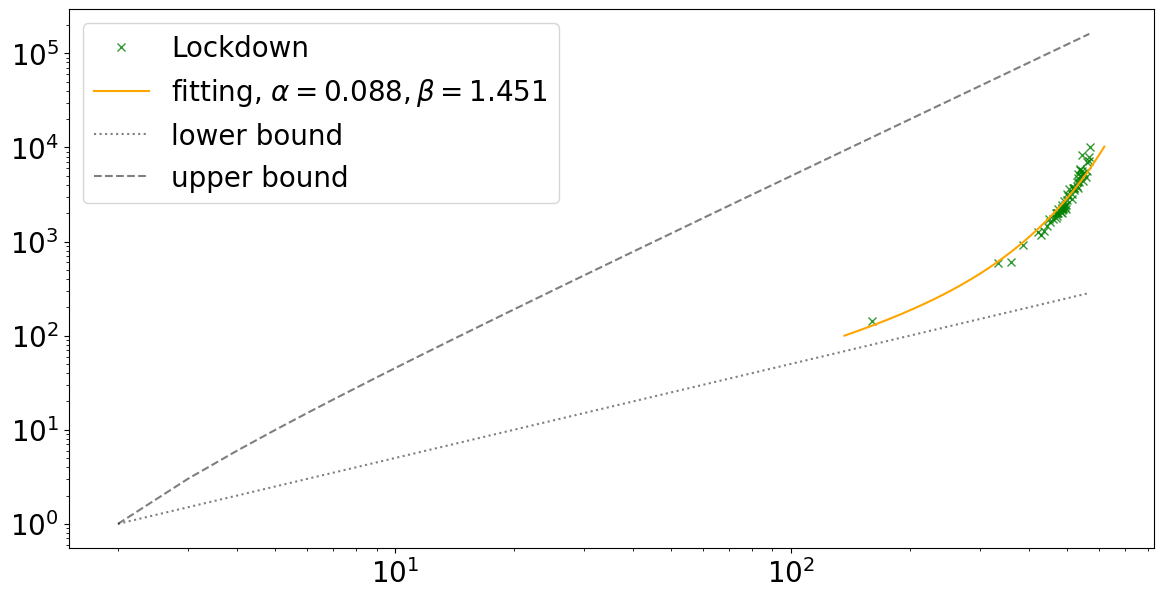

In [53]:
# lockdownにおけるネットワークのノード数とエッジ数の推移
plt.figure(figsize=(14, 7))

N = node_lockdown
M = edge_lockdown

x = np.arange(2, np.max(N))
y = np.arange(100, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8, label="Lockdown")

Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)


#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

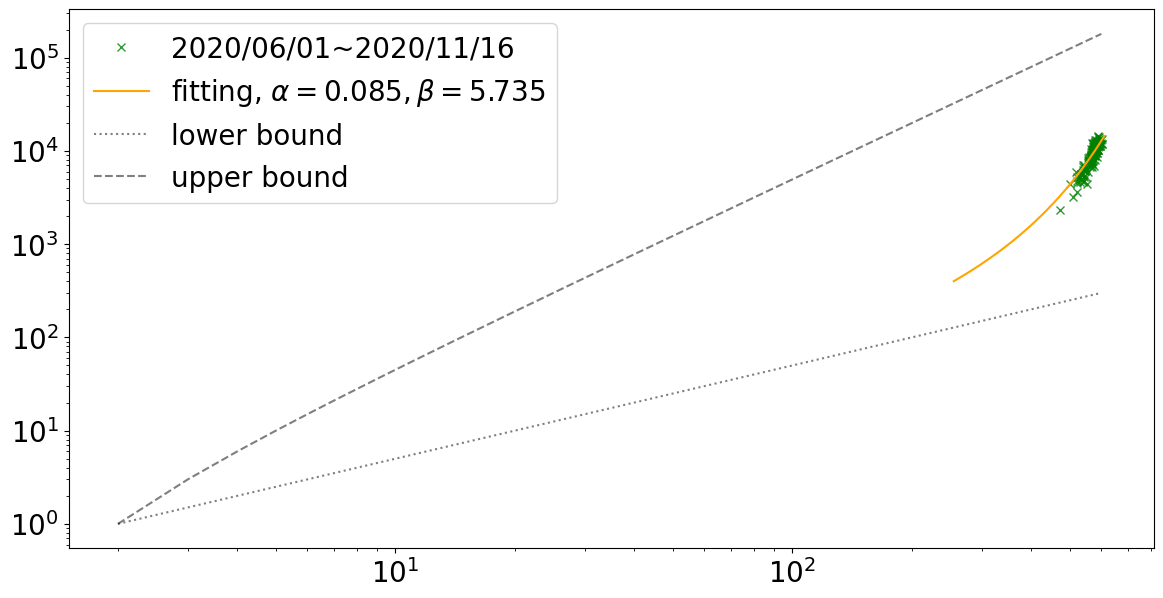

In [57]:
# lockdownにおけるネットワークのノード数とエッジ数の推移
plt.figure(figsize=(14, 7))

N = node_20200601_20201116
M = edge_20200601_20201116

x = np.arange(2, np.max(N))
y = np.arange(400, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8, label="2020/06/01~2020/11/16")

Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)


#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

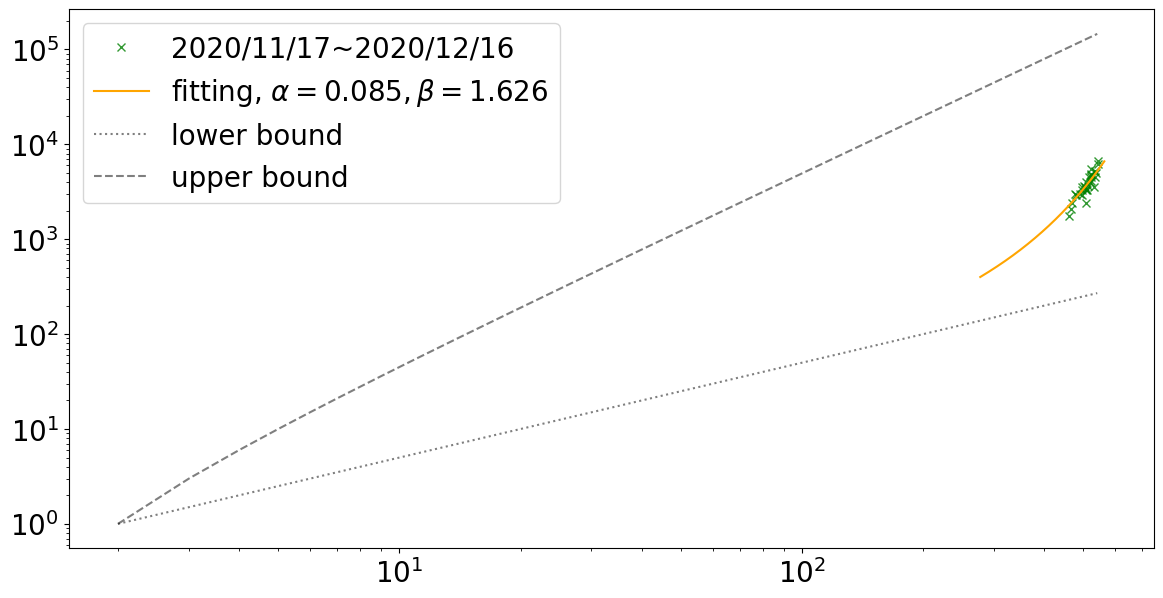

In [58]:
# lockdownにおけるネットワークのノード数とエッジ数の推移
plt.figure(figsize=(14, 7))

N = node_20201117_20201216
M = edge_20201117_20201216

x = np.arange(2, np.max(N))
y = np.arange(400, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8, label="2020/11/17~2020/12/16")

Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)


#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

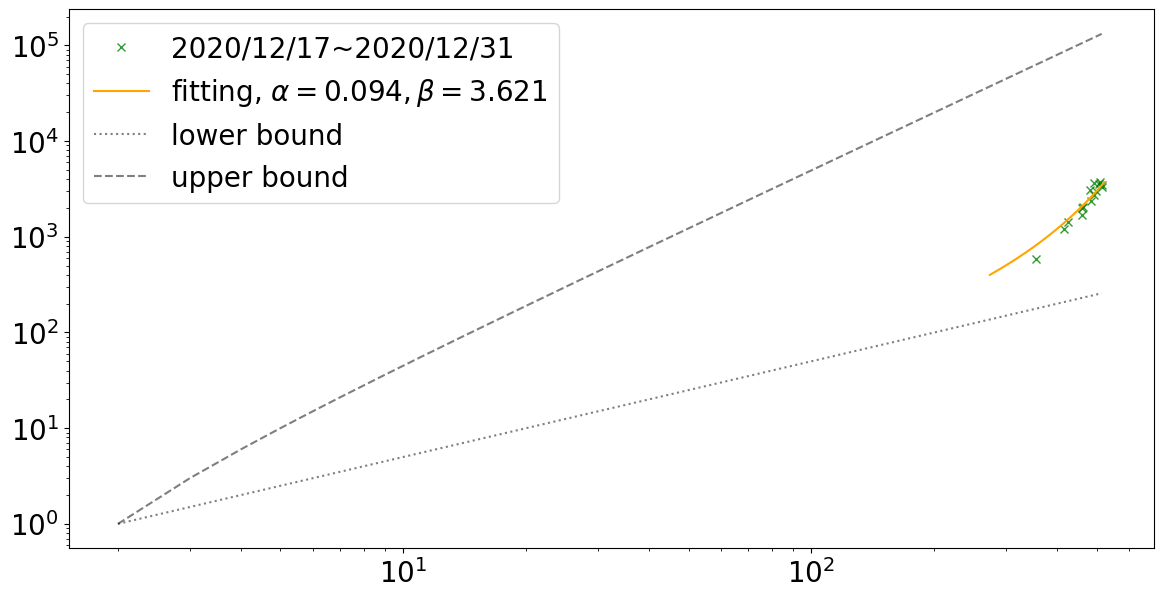

In [59]:
# lockdownにおけるネットワークのノード数とエッジ数の推移
plt.figure(figsize=(14, 7))

N = node_20201217_20201231
M = edge_20201217_20201231

x = np.arange(2, np.max(N))
y = np.arange(400, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8, label="2020/12/17~2020/12/31")

Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)


#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

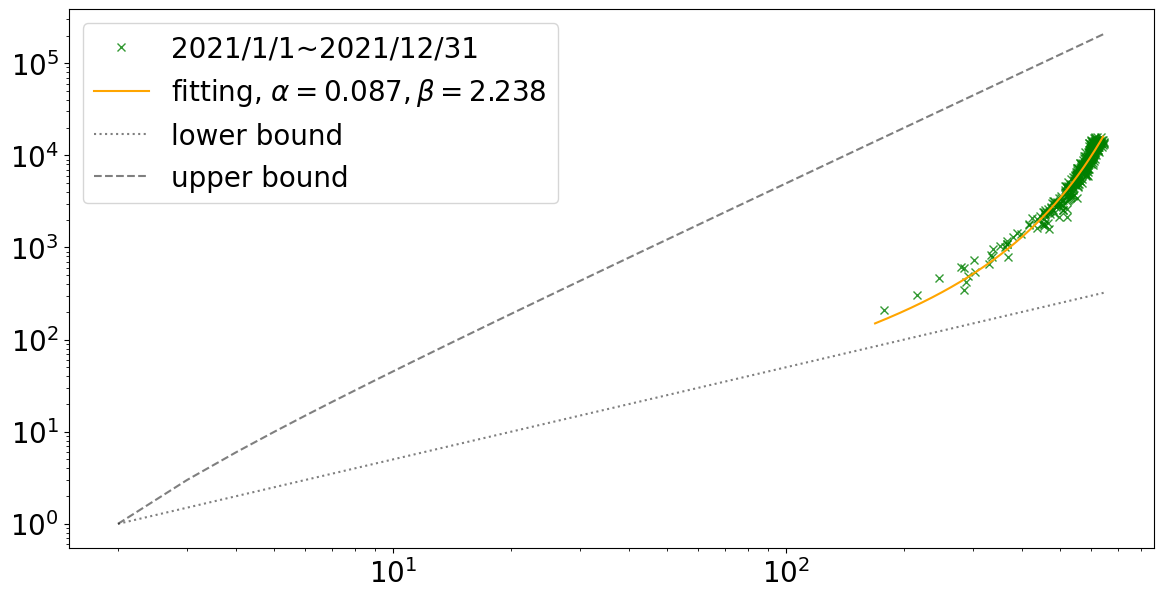

In [63]:
# lockdownにおけるネットワークのノード数とエッジ数の推移
plt.figure(figsize=(14, 7))

N = node_2021
M = edge_2021

x = np.arange(2, np.max(N))
y = np.arange(150, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8, label="2021/1/1~2021/12/31")

Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)


#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

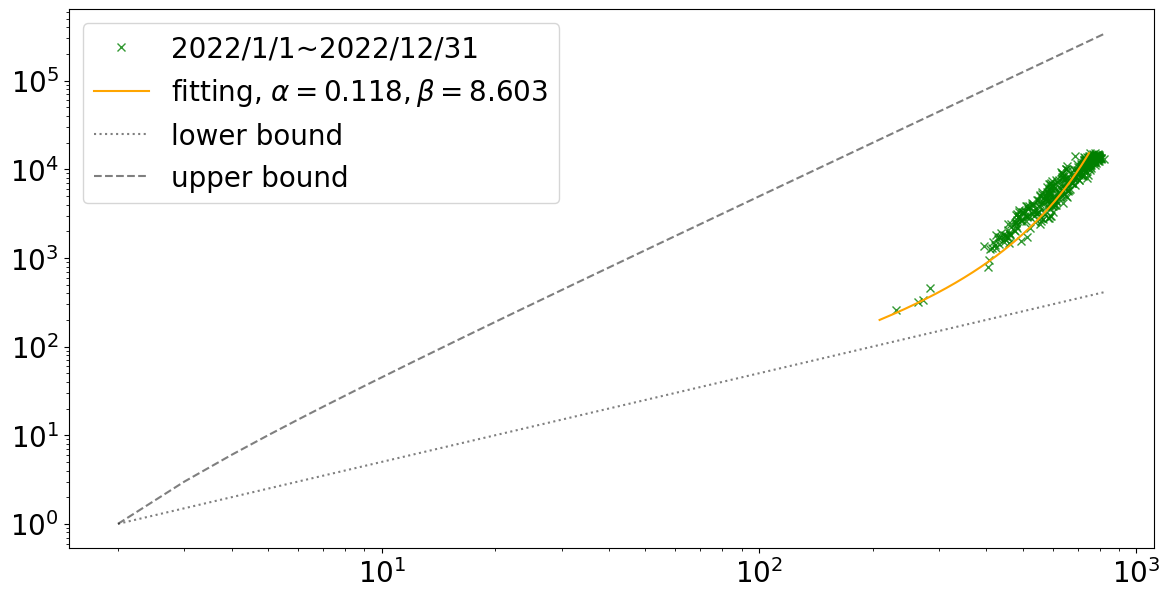

In [64]:
# lockdownにおけるネットワークのノード数とエッジ数の推移
plt.figure(figsize=(14, 7))

N = node_2022
M = edge_2022

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8, label="2022/1/1~2022/12/31")

Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)


#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

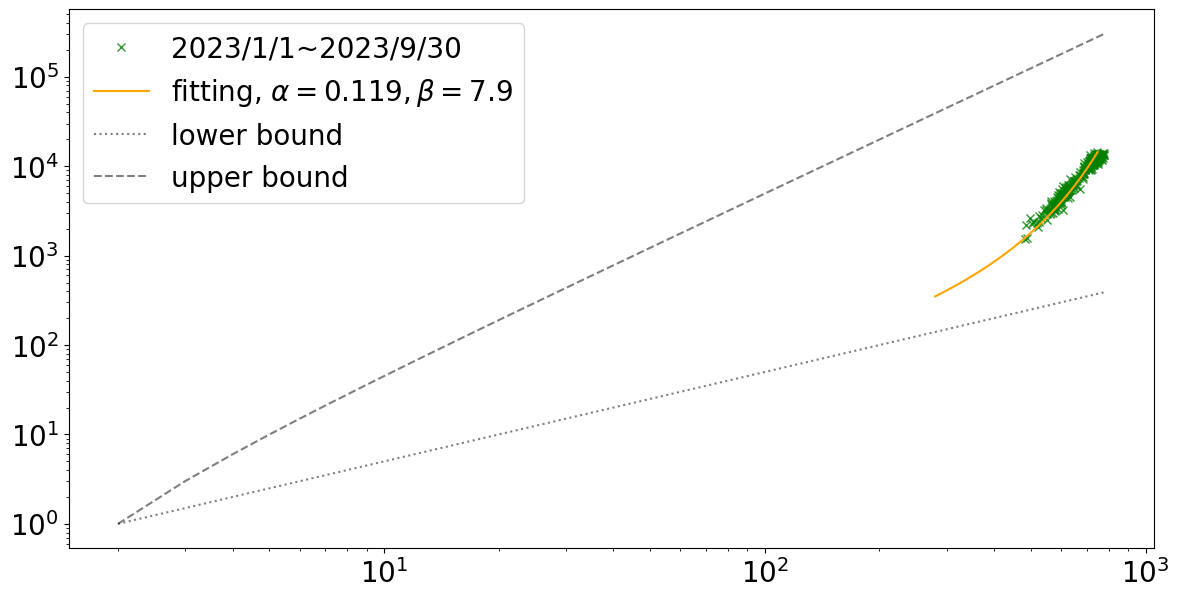

In [67]:
# lockdownにおけるネットワークのノード数とエッジ数の推移
plt.figure(figsize=(14, 7))

N = node_2023
M = edge_2023

x = np.arange(2, np.max(N))
y = np.arange(350, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8, label="2023/1/1~2023/9/30")

Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)


#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

In [69]:
alpha_list = [0.088, 0.085, 0.085, 0.094, 0.087, 0.118, 0.119]
beta_list = [1.451, 5.735, 1.626, 3.621, 2.238, 8.603, 7.9]
label_list = ["Lockdown", "2020/06/01~2020/11/16", "2020/11/17~2020/12/16", "2020/12/17~2020/12/31", "2021/1/1~2021/12/31", "2022/1/1~2022/12/31", "2023/1/1~2023/9/30"]

In [70]:
kappa_lockdown = []
kappa_20200601_20201116 = []
kappa_20201117_20201216 = []
kappa_20201217_20201231 = []
kappa_2021 = []
kappa_2022 = []
kappa_2023 = []

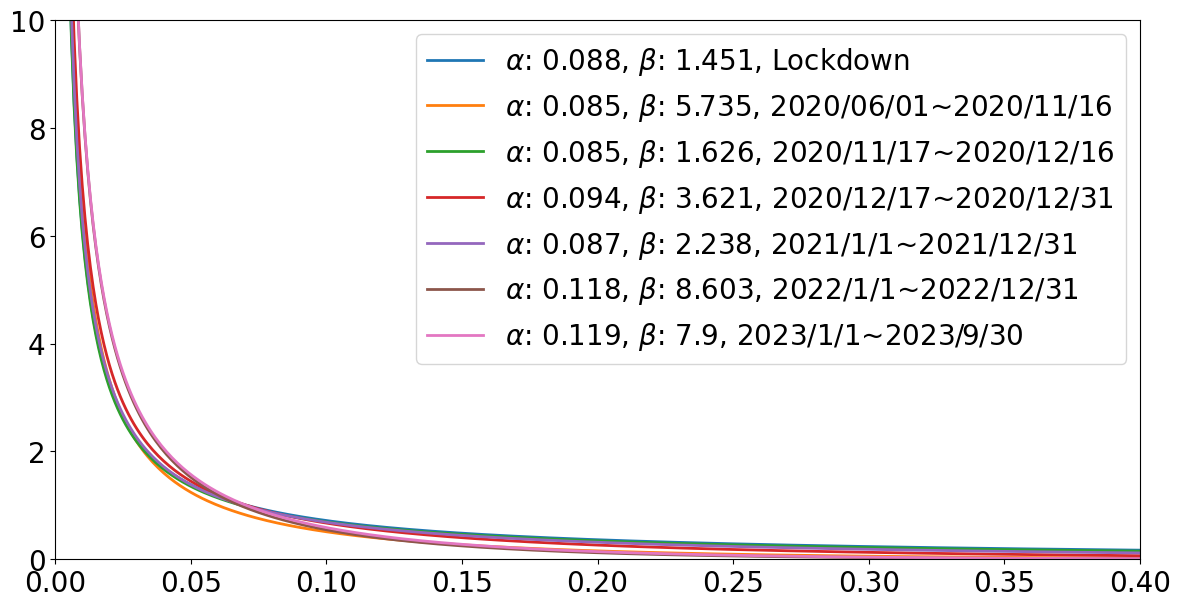

In [83]:
from pyparsing import line


plt.figure(figsize=(14, 7))
a = np.linspace(0, 1, 1000)

for i in range(len(alpha_list)):
    # log-log plot
    plt.plot(a, rho(a, alpha_list[i], beta_list[i]), label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[i], beta_list[i], label_list[i]), linewidth=2)

# x軸の範囲を0.4までに設定
plt.xlim(0, 0.4)
plt.ylim(0, 10)
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

In [84]:
df_2020 = df[df["started_at"] < "2021-01-01"].dropna()

In [88]:
node_2020, edge_2020, timestamp_2020 = getNetworkAnalysis(df_2020)

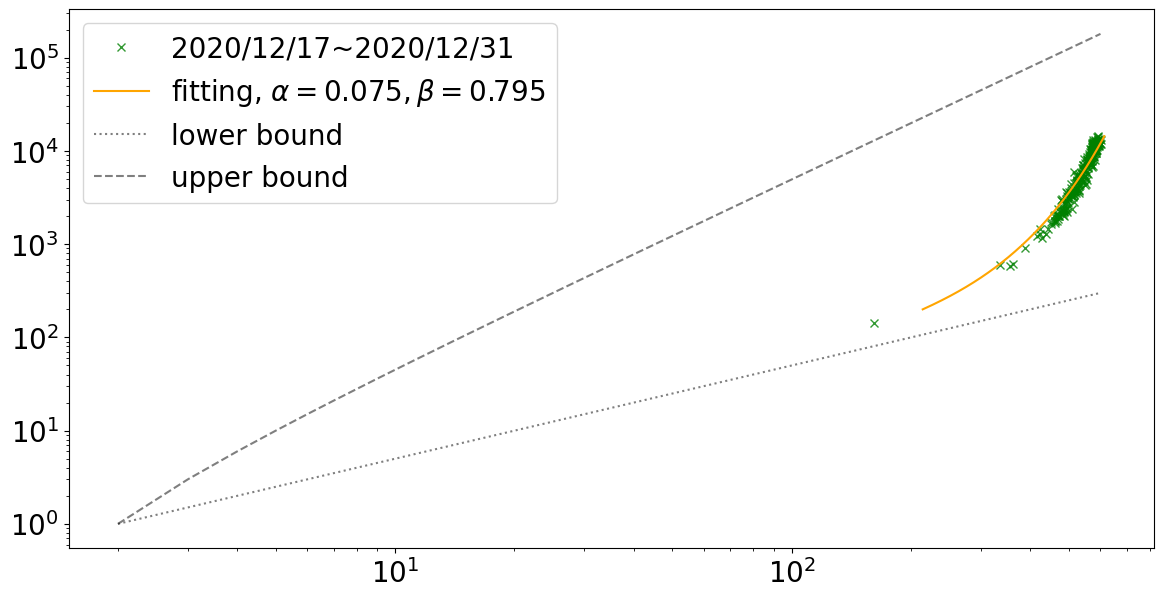

In [89]:
# lockdownにおけるネットワークのノード数とエッジ数の推移
plt.figure(figsize=(14, 7))

N = node_2020
M = edge_2020

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8, label="2020/12/17~2020/12/31")

Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)


#plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

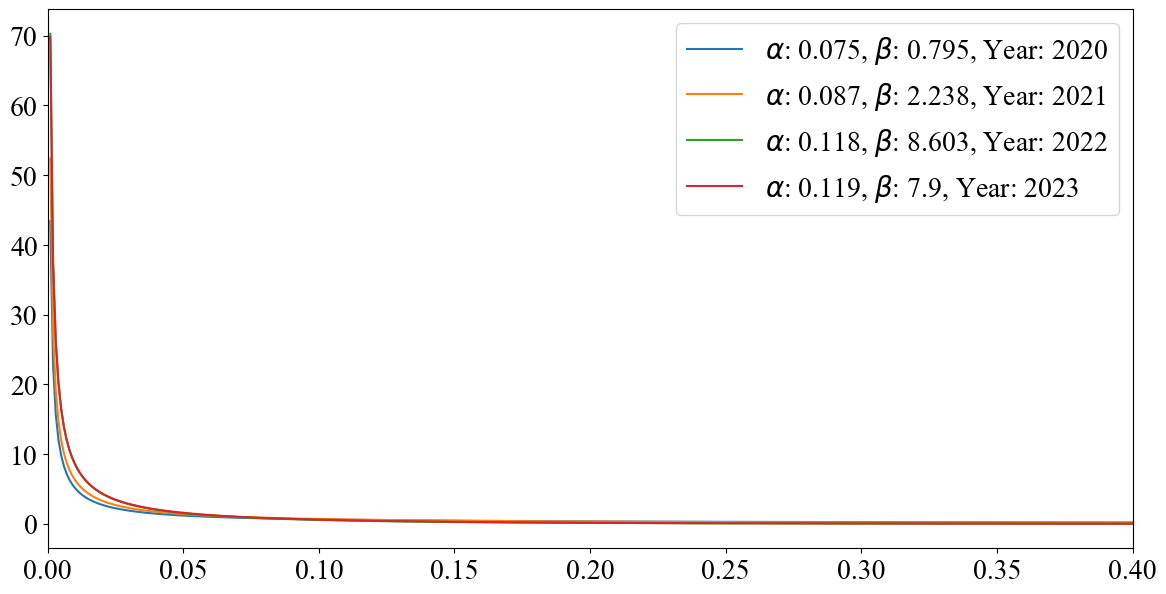

In [97]:
alpha_list = [0.075, 0.087, 0.118, 0.119]
beta_list = [0.795, 2.238, 8.603, 7.9]

plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

a = np.linspace(0, 1, 1000)
label_list = ['Year: 2020', 'Year: 2021', 'Year: 2022', 'Year: 2023']

for i in range(len(alpha_list)):
    # log-log plot
    plt.plot(a, rho(a, alpha_list[i], beta_list[i]), label=r'$\alpha$: {}, $\beta$: {}, {}'.format(alpha_list[i], beta_list[i], label_list[i]), )

# x軸の範囲を0.4までに設定
plt.xlim(0, 0.4)
#plt.ylim(0, 40)
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

In [215]:
rho_2020 = rho(a, alpha_list[0], beta_list[0])
rho_2021 = rho(a, alpha_list[1], beta_list[1])
rho_2022 = rho(a, alpha_list[2], beta_list[2])
rho_2023 = rho(a, alpha_list[3], beta_list[3])


rho_2020 = np.array(rho_2020)
rho_2020 = rho_2020[np.isfinite(rho_2020)]

rho_2021 = np.array(rho_2021)
rho_2021 = rho_2021[np.isfinite(rho_2021)]

rho_2022 = np.array(rho_2022)
rho_2022 = rho_2022[np.isfinite(rho_2022)]

rho_2023 = np.array(rho_2023)
rho_2023 = rho_2023[np.isfinite(rho_2023)]

# power law fitting
fit_2020 = powerlaw.Fit(rho_2020)
fit_2021 = powerlaw.Fit(rho_2021)
fit_2022 = powerlaw.Fit(rho_2022)
fit_2023 = powerlaw.Fit(rho_2023)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


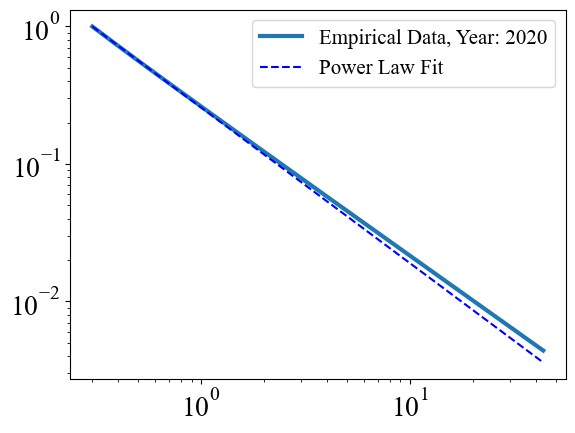

In [216]:
fig = fit_2020.plot_ccdf(linewidth=3, label='Empirical Data, Year: 2020')
fit_2020.power_law.plot_ccdf(ax=fig, color='b', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 15})

In [217]:
R, p = fit_2020.distribution_compare('power_law', 'exponential')
R_lognormal, p_lognormal = fit_2020.distribution_compare('power_law', 'lognormal')

# 結果の出力
print(f"冪乗則 vs 指数分布: R = {R}, p = {p}")
print(f"冪乗則 vs 対数正規分布: R = {R_lognormal}, p = {p_lognormal}")

冪乗則 vs 指数分布: R = 121.57188607607452, p = 0.0005424570320721734
冪乗則 vs 対数正規分布: R = -0.019823354943179772, p = 0.902132262515384


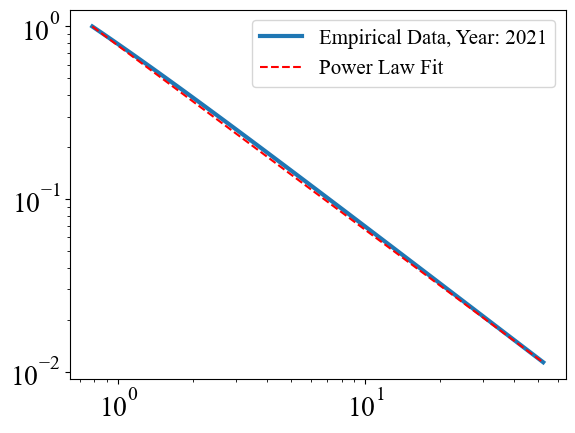

In [218]:
fig = fit_2021.plot_ccdf(linewidth=3, label='Empirical Data, Year: 2021')
fit_2021.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 15})

In [219]:
R, p = fit_2021.distribution_compare('power_law', 'exponential')
R_lognormal, p_lognormal = fit_2021.distribution_compare('power_law', 'lognormal')

# 結果の出力
print(f"冪乗則 vs 指数分布: R = {R}, p = {p}")
print(f"冪乗則 vs 対数正規分布: R = {R_lognormal}, p = {p_lognormal}")

冪乗則 vs 指数分布: R = 33.023600407558085, p = 0.014856233183767319
冪乗則 vs 対数正規分布: R = -0.2977110637314091, p = 0.6221614396675637


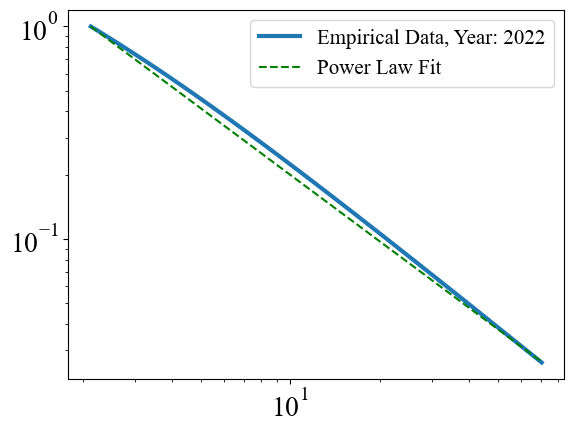

In [220]:
fig = fit_2022.plot_ccdf(linewidth=3, label='Empirical Data, Year: 2022')
fit_2022.power_law.plot_ccdf(ax=fig, color='g', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 15})

In [221]:
R, p = fit_2022.distribution_compare('power_law', 'exponential')
R_lognormal, p_lognormal = fit_2022.distribution_compare('power_law', 'lognormal')

# 結果の出力
print(f"冪乗則 vs 指数分布: R = {R}, p = {p}")
print(f"冪乗則 vs 対数正規分布: R = {R_lognormal}, p = {p_lognormal}")

冪乗則 vs 指数分布: R = 8.558293174501115, p = 0.13144254998641453
冪乗則 vs 対数正規分布: R = -0.4407754199234666, p = 0.5377921966872016


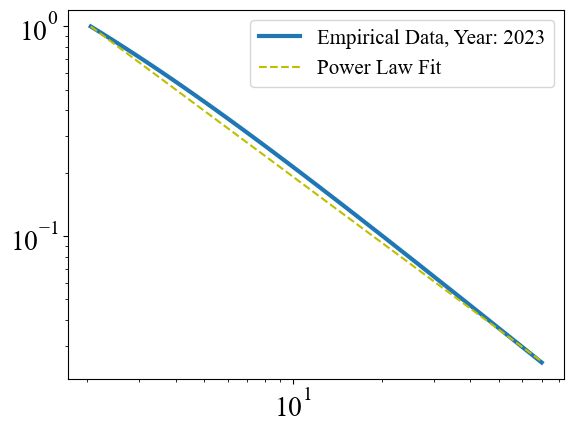

In [222]:
fig = fit_2023.plot_ccdf(linewidth=3, label='Empirical Data, Year: 2023')
fit_2023.power_law.plot_ccdf(ax=fig, color='y', linestyle='--', label='Power Law Fit')

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 15})

In [223]:
R, p = fit_2023.distribution_compare('power_law', 'exponential')
R_lognormal, p_lognormal = fit_2023.distribution_compare('power_law', 'lognormal')

# 結果の出力
print(f"冪乗則 vs 指数分布: R = {R}, p = {p}")
print(f"冪乗則 vs 対数正規分布: R = {R_lognormal}, p = {p_lognormal}")

冪乗則 vs 指数分布: R = 9.266283507633013, p = 0.11896155936128146
冪乗則 vs 対数正規分布: R = -0.43743402824523514, p = 0.5397656314038413


In [118]:
# ロックダウン解除と自宅待機勧告

alpha_stay = [0.085, 0.085]
beta_stat = [5.735, 1.626]

kappa_list_before = []
kappa_list_after = []

for i in range(len(edge_20200601_20201116)):
    kappa_list_before.append(kappa(edge_20200601_20201116[i], Np))

for i in range(len(edge_20201117_20201216)):
    kappa_list_after.append(kappa(edge_20201117_20201216[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_list_before, len(kappa_list_after)), kappa_list_after)[0, 1])
    


0.22056098000312782


In [141]:
alpha = [0.088, 0.087]
beta = [1.451, 2.238]

kappa_a = []
kappa_b = []

for i in range(len(edge_lockdown)):
    alpha = 0.088
    beta = 1.451
    kappa_a.append(kappa(edge_lockdown[i], Np))

for i in range(len(edge_2021)):
    alpha = 0.087
    beta = 2.238
    kappa_b.append(kappa(edge_2021[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_a, len(kappa_b)), kappa_b)[0, 1])

-0.10816556556166614


In [142]:
kappa_a = []
kappa_b = []

for i in range(len(edge_20201117_20201216)):
    alpha = 0.085
    beta = 1.626
    kappa_a.append(kappa(edge_20201117_20201216[i], Np))

for i in range(len(edge_2021)):
    alpha = 0.087
    beta = 2.238
    kappa_b.append(kappa(edge_2021[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_a, len(kappa_b)), kappa_b)[0, 1])

0.10678960918093057


In [145]:
kappa_a = []
kappa_b = []

for i in range(len(edge_lockdown)):
    alpha = 0.088
    beta = 1.451
    kappa_a.append(kappa(edge_lockdown[i], Np))

for i in range(len(edge_2022)):
    alpha = 0.118
    beta = 8.603
    kappa_b.append(kappa(edge_2022[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_a, len(kappa_b)), kappa_b)[0, 1])

0.056882324306535705


In [148]:
kappa_a = []
kappa_b = []

for i in range(len(edge_20201117_20201216)):
    alpha = 0.085
    beta = 1.626
    kappa_a.append(kappa(edge_20201117_20201216[i], Np))

for i in range(len(edge_2023)):
    alpha = 0.119
    beta = 7.9
    kappa_b.append(kappa(edge_2023[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_b, len(kappa_a)), kappa_a)[0, 1])

-0.08206065176702934


In [149]:
kappa_a = []
kappa_b = []

for i in range(len(edge_lockdown)):
    alpha = 0.088
    beta = 1.451
    kappa_a.append(kappa(edge_lockdown[i], Np))

for i in range(len(edge_2023)):
    alpha = 0.119
    beta = 7.9
    kappa_b.append(kappa(edge_2023[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(kappa_b, len(kappa_a)), kappa_a)[0, 1])

-0.04213304328564475


In [150]:
sah = []
asah = []

for i in range(len(edge_20201117_20201216)):
    alpha = 0.085
    beta = 1.626
    sah.append(kappa(edge_20201117_20201216[i], Np))

for i in range(len(edge_20201217_20201231)):
    alpha = 0.094
    beta = 3.621
    asah.append(kappa(edge_20201217_20201231[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(sah, len(asah)), asah)[0, 1])

-0.22916283257637862


In [154]:
# df_2020_normalのalphaとbetaの推定
node_2020_normal, edge_2020_normal, timestamp_2020_normal = getNetworkAnalysis(df_2020_normal)

N = node_2020_normal
M = edge_2020_normal

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))


Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

print("alpha: ", alpha)
print("beta: ", beta)

alpha:  0.081
beta:  1.761


In [158]:
lockdown = []
normal = []

for i in range(len(edge_lockdown)):
    alpha = 0.088
    beta = 1.451
    lockdown.append(kappa(edge_lockdown[i], Np))

for i in range(len(edge_2020_normal)):
    alpha = 0.081
    beta = 1.761
    normal.append(kappa(edge_2020_normal[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(normal, len(lockdown)), lockdown)[0, 1])

0.03244752231521197


In [156]:
print(len(lockdown))
print(len(normal))

61
212


In [162]:
stay = []
normal = []

for i in range(len(edge_20201117_20201216)):
    alpha = 0.085
    beta = 1.626
    stay.append(kappa(edge_20201117_20201216[i], Np))

for i in range(len(edge_2020_normal)):
    alpha = 0.081
    beta = 1.761
    normal.append(kappa(edge_2020_normal[i], Np))

# 相関係数
print(np.corrcoef(np.random.choice(normal, len(stay)), stay)[0, 1])

-0.33518701420588415


In [161]:
print(len(stay))
print(len(normal))

30
212


In [164]:
# 距離とkappaの回帰分析
node_df, edge_df, timestamp_df, distance_df = getNetworkAnalysis(df)


In [180]:
len(edge_df)

1278

In [181]:
len(distance_df)

1278

In [182]:
len(kappa_distance["kappa"])

1278

In [165]:
params, _ = optimize.curve_fit(Model3_fixed, edge_df, node_df, p0=[1,1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

# 活動量の計算
kappa_list = []
for i in range(len(edge_df)):
    kappa_list.append(kappa(edge_df[i], Np))

In [170]:
kappa_distance = pd.DataFrame({"kappa": kappa_list, "distance": distance_df})
kappa_distance.head()

,kappa,distance
0,1.417870,2.180333
1,1.553073,2.225399
2,2.026641,2.362661
3,1.321599,2.301933
4,1.578557,2.408816


In [172]:
# olsを使用して分析を行う
formula = "distance ~ kappa"
res = ols(formula, data=kappa_distance).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     989.2
Date:                Sat, 20 Jan 2024   Prob (F-statistic):          3.63e-161
Time:                        19:42:50   Log-Likelihood:                -187.90
No. Observations:                1276   AIC:                             379.8
Df Residuals:                    1274   BIC:                             390.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8130      0.017    106.631      0.0

In [173]:
# resをlatex形式で出力する
print(res.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     distance     & \textbf{  R-squared:         } &      0.437    \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &      0.437    \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &      989.2    \\
\textbf{Date:}             & Sat, 20 Jan 2024 & \textbf{  Prob (F-statistic):} &  3.63e-161    \\
\textbf{Time:}             &     19:43:21     & \textbf{  Log-Likelihood:    } &    -187.90    \\
\textbf{No. Observations:} &        1276      & \textbf{  AIC:               } &      379.8    \\
\textbf{Df Residuals:}     &        1274      & \textbf{  BIC:               } &      390.1    \\
\textbf{Df Model:}         &           1      & \textbf{                     } &               \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &               \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                   & 

In [176]:
distance_hat = res.fittedvalues

In [178]:
len(kappa_distance)

1278

In [179]:
len(distance_hat)

1276

In [206]:
x = kappa_distance["kappa"]
y = kappa_distance["distance"]

def func(kappa):
    return kappa*kappa

model = smf.ols(formula='distance ~ kappa', data=kappa_distance).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     989.2
Date:                Sat, 20 Jan 2024   Prob (F-statistic):          3.63e-161
Time:                        20:11:57   Log-Likelihood:                -187.90
No. Observations:                1276   AIC:                             379.8
Df Residuals:                    1274   BIC:                             390.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8130      0.017    106.631      0.0

In [208]:
print(model.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &     distance     & \textbf{  R-squared:         } &      0.437    \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &      0.437    \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &      989.2    \\
\textbf{Date:}             & Sat, 20 Jan 2024 & \textbf{  Prob (F-statistic):} &  3.63e-161    \\
\textbf{Time:}             &     20:12:15     & \textbf{  Log-Likelihood:    } &    -187.90    \\
\textbf{No. Observations:} &        1276      & \textbf{  AIC:               } &      379.8    \\
\textbf{Df Residuals:}     &        1274      & \textbf{  BIC:               } &      390.1    \\
\textbf{Df Model:}         &           1      & \textbf{                     } &               \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &               \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                   & 

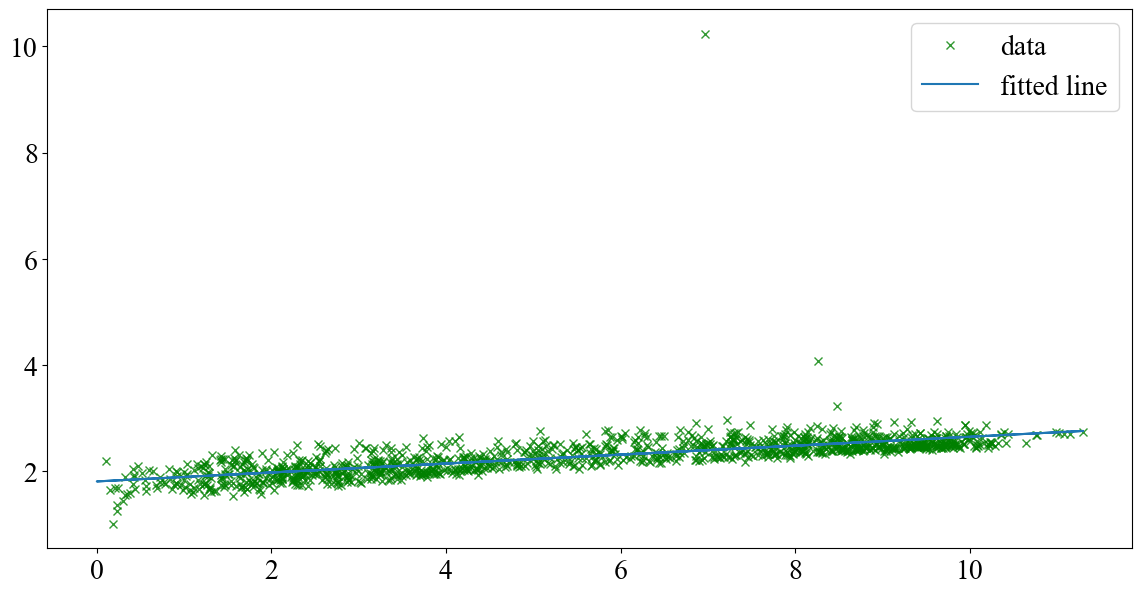

In [207]:
# プロット
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(x, y, "x", c="green", alpha=0.8, label="data")
plt.plot(x, model.predict(x), label="fitted line")

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()


In [188]:
x

0       1.417870
1       1.553073
2       2.026641
3       1.321599
4       1.578557
          ...   
1273    6.868492
1274    7.575658
1275    8.275744
1276    8.302643
1277    8.694805
Name: kappa, Length: 1278, dtype: float64

In [209]:
y

0       2.180333
1       2.225399
2       2.362661
3       2.301933
4       2.408816
          ...   
1273    2.291989
1274    2.308310
1275    2.359183
1276    2.356731
1277    2.568510
Name: distance, Length: 1278, dtype: float64